# Exploratory Data Analysis 

Presents descriptive statistics for a dataset that was available as a part of Azure AI Notebooks, published by Microsoft Azure and used for predictive maintenence modeling.

https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance

In [1]:
%load_ext autoreload
%autoreload 1

In [37]:
import numpy as np
import pandas as pd
import datetime
import copy
import time
import os
import re
import matplotlib.pyplot as plt
import operator
import warnings
warnings.filterwarnings('ignore')


from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

There are 5 files, `PdM_errors.csv`, `PdM_failures.csv`, `PdM_machines.csv`, `PdM_maint.csv`, and `PdM_telemetry.csv`.

Let's examine `PdM_machines.csv` first.

In [3]:
machines_df = pd.read_csv('data/PdM_machines.csv')
machines_df

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [4]:
machines_df.model.unique()

array(['model3', 'model4', 'model2', 'model1'], dtype=object)

In [5]:
machines_df.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


`PdM_machines.csv` describes 100 different machines, each being 1 of 4 models and an age ranging from 0 to 20 years old. The average age of all the machines is 11.33 years.

In [6]:
machines_df.model.value_counts()

model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

In total, there are 35 model 3, 32 model 4, 17 model 2, and 16 model 1 machines. 

Now, let's examine `PdM_telemetry.csv`.

In [7]:
telemetry_df = pd.read_csv('data/PdM_telemetry.csv')
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])
telemetry_df = telemetry_df.sort_values(by=['machineID'])
telemetry_df = telemetry_df.reset_index(drop=True)

In [8]:
telemetry_df

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-09-01 23:00:00,1,154.428051,465.161706,88.559244,56.990647
2,2015-09-01 22:00:00,1,176.517110,401.772365,84.175180,67.633435
3,2015-09-01 21:00:00,1,161.601742,436.007029,90.647182,63.251945
4,2015-09-01 20:00:00,1,162.926562,522.264401,90.153285,61.426953
...,...,...,...,...,...,...
876095,2015-05-02 23:00:00,100,172.510014,307.093606,102.147513,46.077955
876096,2015-05-03 00:00:00,100,179.571114,298.871288,92.270089,41.345416
876097,2015-05-03 01:00:00,100,174.457164,342.979173,107.629133,39.820334
876098,2015-05-02 19:00:00,100,163.184820,451.380085,108.990921,40.935406


The dataset is stored in a pandas table. Each row in the table corresponds to a timestamped record of each machine. 

The columns of the dataset are datetime, machineID, volt, rotate, pressure, vibration. These values are the hourly average collected from each machineID for the year 2015. Since there are 8761 hours in a year, we can assume that the machines are running 24 hours a day, with 100 machines that is 876100 rows. 

In [9]:
telemetry_df.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [10]:
before = telemetry_df.shape[0]
mask = telemetry_df.duplicated()
telemetry_df = telemetry_df[~mask]
telemetry_df.reset_index(drop=True, inplace=True)
after = telemetry_df.shape[0]
print(f"There were {before - after} duplicates.")

There were 0 duplicates.


In [11]:
print('Starting Date:', telemetry_df['datetime'].min())
print('Starting Date:', telemetry_df['datetime'].max())

Starting Date: 2015-01-01 06:00:00
Starting Date: 2016-01-01 06:00:00


The dataset ranges from January 1st, 2015 to January 1st, 2016

Let's plot the vibration of machine 21 for 2015

<AxesSubplot:xlabel='Time', ylabel='Vibration'>

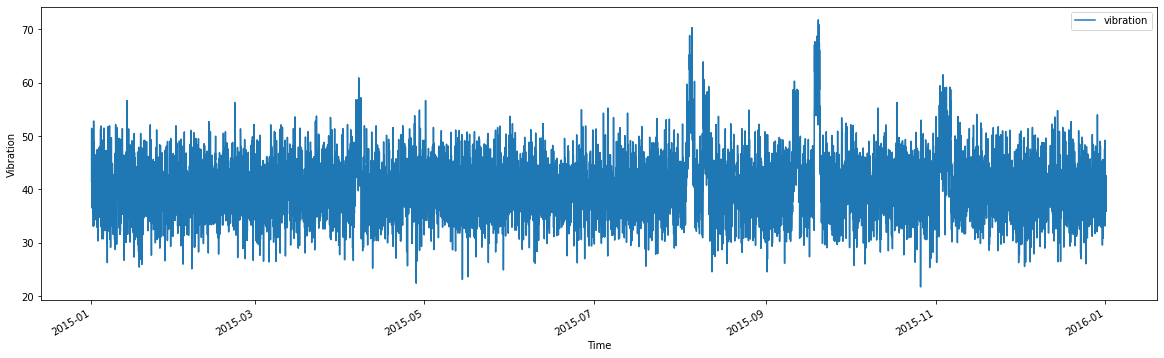

In [12]:
telemetry_df.loc[telemetry_df['machineID'] == 21].plot(x='datetime', y='vibration', figsize=(20,6), xlabel='Time', ylabel='Vibration')

Let's plot voltage of machine 94 for the first 2 weeks of 2015

<AxesSubplot:xlabel='Time', ylabel='Voltage'>

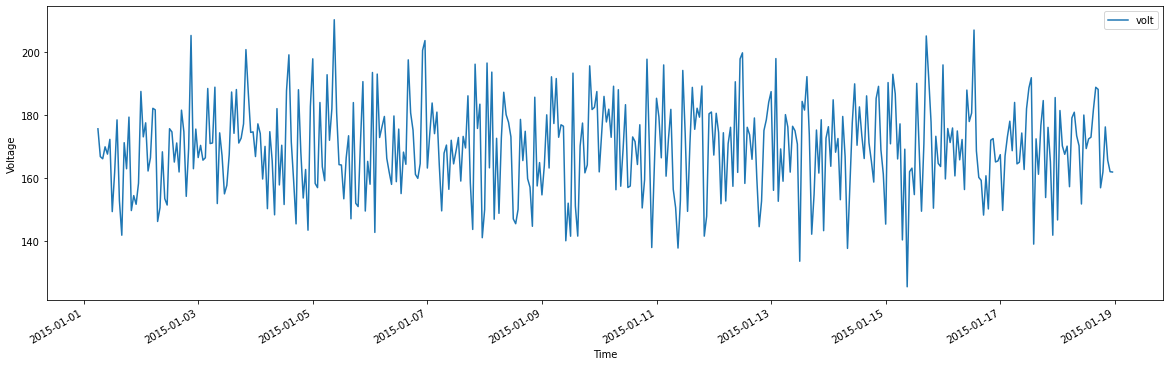

In [13]:
first_two_weeks_mach1 = telemetry_df[(telemetry_df.machineID == 94) & (telemetry_df.datetime.dt.isocalendar().week.isin([1,2,3]))]
first_two_weeks_mach1.plot(x='datetime', y='volt', figsize=(20,6), xlabel='Time', ylabel='Voltage')

<AxesSubplot:title={'center':'volt'}, xlabel='year_month'>

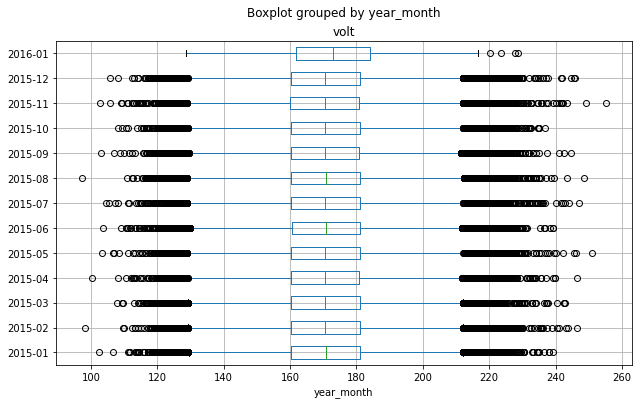

In [14]:
telemetry_df_datefeatures = telemetry_df.copy()
telemetry_df_datefeatures['year_month'] = pd.to_datetime(telemetry_df_datefeatures['datetime']).dt.to_period('M')
telemetry_df_datefeatures.boxplot(column='volt', by='year_month', vert=False, figsize=(10,6))

The voltage across the machines is not varying over each month. We can ignore the entry for 2016, since there is only 1 data point in 2016.

Now, let's plot the distribution.

<AxesSubplot:title={'center':'Distribution of voltage'}, ylabel='Frequency'>

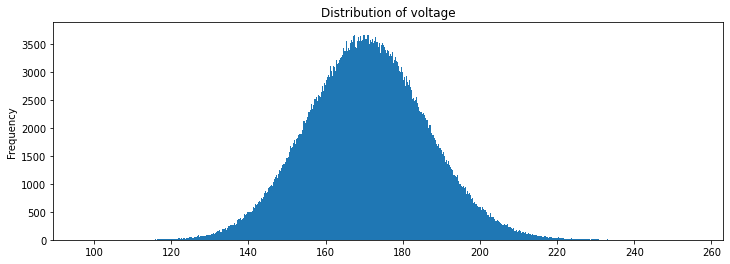

In [15]:
telemetry_df['volt'].plot(kind='hist', bins=1000, figsize=(12,4), title='Distribution of voltage')

<AxesSubplot:title={'center':'Distribution of rotation'}, ylabel='Frequency'>

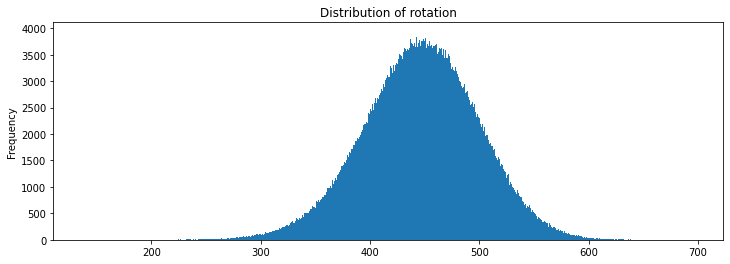

In [16]:
telemetry_df['rotate'].plot(kind='hist', bins=1000, figsize=(12,4), title='Distribution of rotation')

<AxesSubplot:title={'center':'Distribution of pressure'}, ylabel='Frequency'>

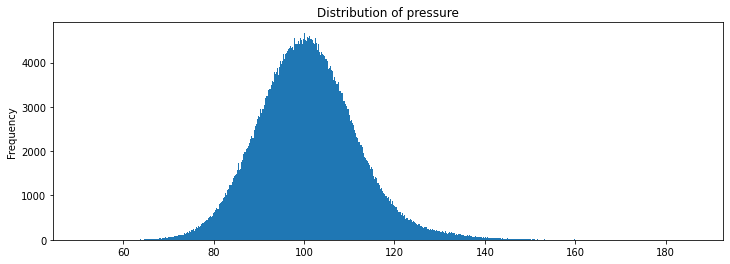

In [17]:
telemetry_df['pressure'].plot(kind='hist', bins=1000, figsize=(12,4), title='Distribution of pressure')

<AxesSubplot:title={'center':'Distribution of vibration'}, ylabel='Frequency'>

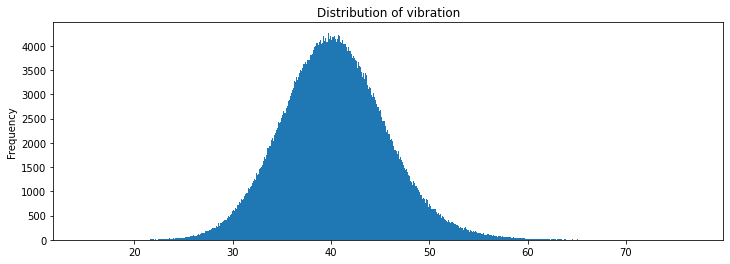

In [18]:
telemetry_df['vibration'].plot(kind='hist', bins=1000, figsize=(12,4), title='Distribution of vibration')

A couple observations on `PdM_telemetry.csv`
- Since all the characteristics of the telemetry data follows a normal distribution, it could be possible that it is synthetically created data.
- There are 100 unique machines
- Each row represents the state of machine on a particular hour. The voltage, rotation, pressure and vibration have been averaged over the hour.

Now, let's view `PdM_errors.csv`

In [19]:
error_df = pd.read_csv('data/PdM_errors.csv')
error_df['datetime'] = pd.to_datetime(error_df['datetime'])
error_df

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [20]:
error_df.errorID.unique()

array(['error1', 'error3', 'error5', 'error4', 'error2'], dtype=object)

In [21]:
error_df.errorID.value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

`PdM_errors.csv` describes the errors that a machine encounter's during it's operation. Errors do not stop the machine's operation. There are 5 types of errors that a machine can encounter. The data is stored in a pandas table where each row corresponds to a timestamped record of the error that each machine encountered.

In [22]:
min_date = error_df.datetime.min()
max_date = error_df.datetime.max()
print(f"Error data is collected from {min_date} to {max_date}. ")

Error data is collected from 2015-01-01 06:00:00 to 2016-01-01 05:00:00. 


<AxesSubplot:title={'center':'Types of Errors and their occurence'}, xlabel='Error Type', ylabel='Number of Errors'>

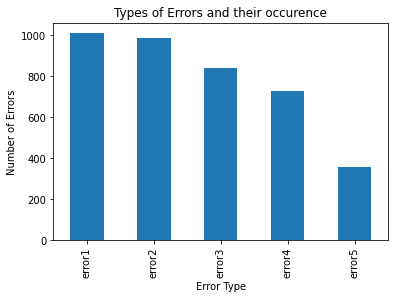

In [23]:
error_df.errorID.value_counts().plot(kind='bar', xlabel='Error Type', ylabel='Number of Errors', title='Types of Errors and their occurence')

The most common types of error is error1 and error2.

<AxesSubplot:title={'center':'Total Number of Errors across days'}, xlabel='Date', ylabel='Number of Errors'>

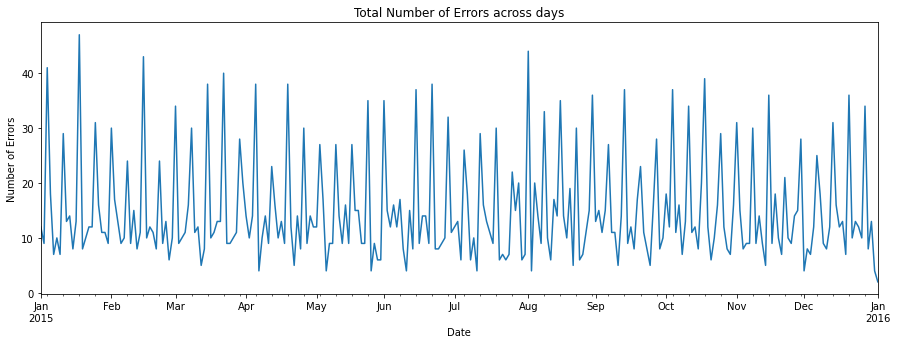

In [24]:
error_df['year_month_day'] = error_df.datetime.dt.to_period('B')
error_df['year_month_day'].value_counts().sort_index().plot(xlabel='Date', ylabel='Number of Errors', figsize=(15,5), title='Total Number of Errors across days')

<AxesSubplot:title={'center':'Distribution of Errors on a particular day'}, ylabel='Frequency'>

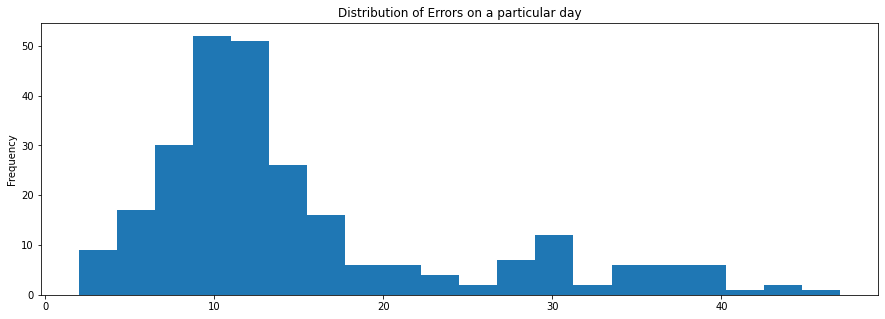

In [25]:
error_df.groupby('year_month_day').size().plot(kind='hist', bins=20, figsize=(15,5), xlabel='Number of Errors on any particular day', title='Distribution of Errors on a particular day')

According to the distribution, there are mostly 9-12 errors per day. The likelihood of 40+ errors occuring per day is small.

Now, let's look at `PdM_failures.csv`

In [26]:
failures_df = pd.read_csv('data/PdM_failures.csv')
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
failures_df

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [27]:
failures_df.failure.unique()

array(['comp4', 'comp1', 'comp2', 'comp3'], dtype=object)

In [28]:
failures_df.failure.value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

Similar to `PdM_errors.csv`, `PdM_failures.csv` describes the failures that a machine encounter's during it's operation. For any given machine, 1 out of the 4 components will fail. The data is stored in a pandas table where each row is a timestamped event of the component that failed for a machine.

<AxesSubplot:title={'center':'Types of Components that fail and their occurence'}, xlabel='Component', ylabel='Number of failures'>

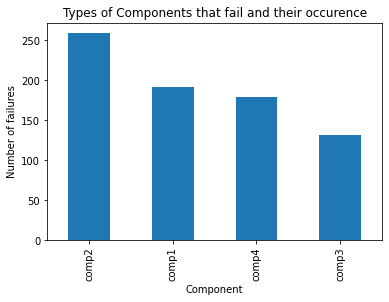

In [29]:
failures_df.failure.value_counts().plot(kind='bar', xlabel='Component', ylabel='Number of failures', title='Types of Components that fail and their occurence')

The component that fails the most is comp2.

In [30]:
failures_df['year_month_day'] = failures_df.datetime.dt.to_period('B')

<AxesSubplot:title={'center':'Total Number of Failures across days'}, xlabel='Date', ylabel='Number of Failures'>

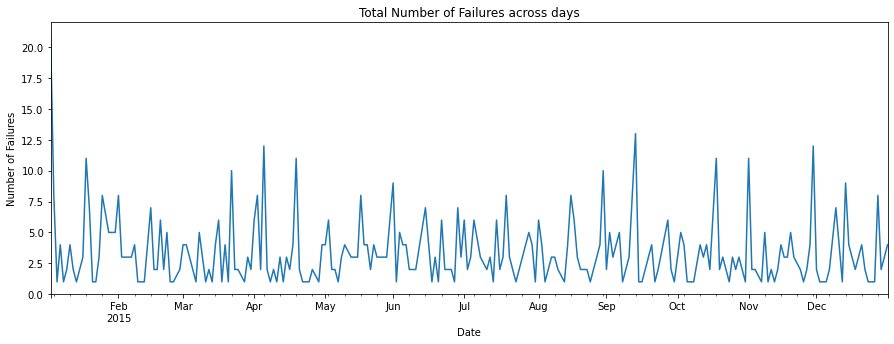

In [31]:
failures_df.year_month_day.value_counts().sort_index().plot(xlabel='Date', ylabel='Number of Failures', title='Total Number of Failures across days', figsize=(15,5))

<AxesSubplot:title={'center':'Distribution of Failures on a particular day'}, ylabel='Frequency'>

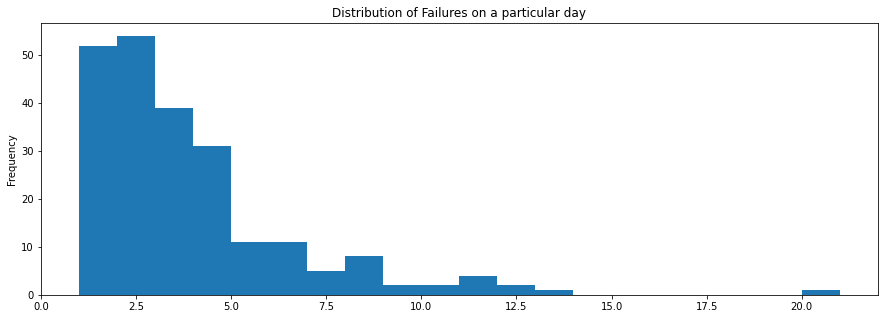

In [32]:
failures_df.groupby('year_month_day').size().plot(kind='hist', bins=20, figsize=(15,5), xlabel='Number of Failures on any particular day', title='Distribution of Failures on a particular day')

Compared to the errors, there are mostly only 1-3 failures per day. It is unlikely that we will experience more than 10 failures in total per day.

Does the number of Errors and Failures correlate to the Machine age?

In [33]:
errors_across_machine = error_df.groupby("machineID").size()
errors_across_machine = pd.DataFrame(errors_across_machine, columns=["num_errors"]).reset_index()
machines_errors_df = pd.merge(machines_df, errors_across_machine, how='left', on="machineID")

failure_across_machine = failures_df.groupby("machineID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["num_failure"]).reset_index()
machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="machineID")

machines_errors_df.head()

,machineID,model,age,num_errors,num_failure
0,1,model3,18,35,7.0
1,2,model4,7,28,4.0
2,3,model3,8,39,5.0
3,4,model3,7,31,6.0
4,5,model3,2,38,7.0


<AxesSubplot:title={'center':'Age vs Number of Errors'}, xlabel='age', ylabel='num_errors'>

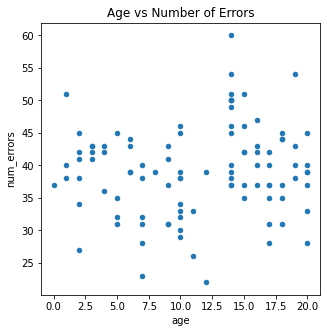

In [34]:
machines_errors_df.plot.scatter("age", "num_errors", figsize=(5,5), title="Age vs Number of Errors")

<AxesSubplot:title={'center':'Age vs Number of Failures'}, xlabel='age', ylabel='num_failure'>

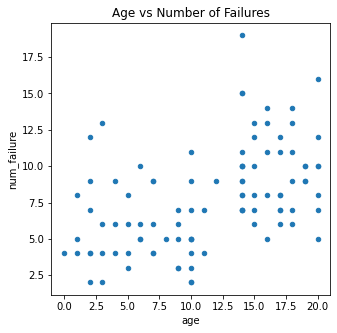

In [35]:
machines_errors_df.plot.scatter("age", "num_failure", figsize=(5,5), title="Age vs Number of Failures")

As shown in the two plots, it appears that the number of failures is slightly correlated with the age of the machine. Let's confirm this with correlation values.

In [36]:
machines_errors_df.corr()

,machineID,age,num_errors,num_failure
machineID,1.000000,0.100196,0.107982,0.096496
age,0.100196,1.000000,0.106931,0.476459
num_errors,0.107982,0.106931,1.000000,0.483735
num_failure,0.096496,0.476459,0.483735,1.000000
